In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "resnet_ce_mse"
ood = "0:1:2:3:4"

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                            | 0/60000 [00:00<?, ?it/s]

 13%|███████▊                                                      | 7527/60000 [00:00<00:00, 75262.71it/s]

 25%|███████████████▎                                             | 15054/60000 [00:00<00:00, 73247.81it/s]

 37%|██████████████████████▊                                      | 22383/60000 [00:00<00:00, 69877.26it/s]

 49%|█████████████████████████████▉                               | 29387/60000 [00:00<00:00, 69560.23it/s]

 62%|█████████████████████████████████████▌                       | 36952/60000 [00:00<00:00, 71693.31it/s]

 74%|████████████████████████████████████████████▊                | 44133/60000 [00:00<00:00, 71024.75it/s]

 86%|████████████████████████████████████████████████████▌        | 51728/60000 [00:00<00:00, 72602.56it/s]

 98%|███████████████████████████████████████████████████████████▉ | 58997/60000 [00:00<00:00, 70923.52it/s]

100%|█████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 71245.03it/s]

  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 73%|█████████████████████████████████████████████                 | 7277/10000 [00:00<00:00, 72766.95it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 72985.29it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 kba5ntt5


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    fpi = 5

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            rcn = x
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        rcn = x
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/383 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/383 [00:00<03:04,  2.07it/s]

  3%|█▊                                                                   | 10/383 [00:00<00:16, 22.08it/s]

  5%|███▍                                                                 | 19/383 [00:00<00:09, 38.69it/s]

  7%|█████                                                                | 28/383 [00:00<00:06, 51.89it/s]

 10%|██████▋                                                              | 37/383 [00:00<00:05, 62.11it/s]

 12%|████████▎                                                            | 46/383 [00:00<00:04, 69.76it/s]

 14%|█████████▉                                                           | 55/383 [00:01<00:04, 75.42it/s]

 17%|███████████▌                                                         | 64/383 [00:01<00:04, 79.49it/s]

 19%|█████████████▏                                                       | 73/383 [00:01<00:03, 82.49it/s]

 21%|██████████████▊                                                      | 82/383 [00:01<00:03, 84.58it/s]

 24%|████████████████▍                                                    | 91/383 [00:01<00:03, 86.03it/s]

 26%|█████████████████▊                                                  | 100/383 [00:01<00:03, 87.15it/s]

 28%|███████████████████▎                                                | 109/383 [00:01<00:03, 87.95it/s]

 31%|████████████████████▉                                               | 118/383 [00:01<00:02, 88.50it/s]

 33%|██████████████████████▌                                             | 127/383 [00:01<00:02, 88.78it/s]

 36%|████████████████████████▏                                           | 136/383 [00:01<00:02, 89.11it/s]

 38%|█████████████████████████▋                                          | 145/383 [00:02<00:02, 89.34it/s]

 40%|███████████████████████████▎                                        | 154/383 [00:02<00:02, 89.47it/s]

 43%|████████████████████████████▉                                       | 163/383 [00:02<00:02, 89.51it/s]

 45%|██████████████████████████████▌                                     | 172/383 [00:02<00:02, 89.64it/s]

 47%|████████████████████████████████▏                                   | 181/383 [00:02<00:02, 89.71it/s]

 50%|█████████████████████████████████▋                                  | 190/383 [00:02<00:02, 89.21it/s]

 52%|███████████████████████████████████▎                                | 199/383 [00:02<00:02, 89.19it/s]

 54%|████████████████████████████████████▉                               | 208/383 [00:02<00:01, 89.34it/s]

 57%|██████████████████████████████████████▌                             | 217/383 [00:02<00:01, 89.53it/s]

 59%|████████████████████████████████████████▏                           | 226/383 [00:02<00:01, 89.57it/s]

 61%|█████████████████████████████████████████▋                          | 235/383 [00:03<00:01, 89.55it/s]

 64%|███████████████████████████████████████████▎                        | 244/383 [00:03<00:01, 89.58it/s]

 66%|████████████████████████████████████████████▉                       | 253/383 [00:03<00:01, 89.45it/s]

 68%|██████████████████████████████████████████████▌                     | 262/383 [00:03<00:01, 89.53it/s]

 71%|████████████████████████████████████████████████                    | 271/383 [00:03<00:01, 89.65it/s]

 73%|█████████████████████████████████████████████████▉                  | 281/383 [00:03<00:01, 89.74it/s]

 76%|███████████████████████████████████████████████████▋                | 291/383 [00:03<00:01, 89.84it/s]

 78%|█████████████████████████████████████████████████████▎              | 300/383 [00:03<00:00, 89.78it/s]

 81%|███████████████████████████████████████████████████████             | 310/383 [00:03<00:00, 89.88it/s]

 83%|████████████████████████████████████████████████████████▋           | 319/383 [00:04<00:00, 89.35it/s]

 86%|██████████████████████████████████████████████████████████▏         | 328/383 [00:04<00:00, 89.52it/s]

 88%|███████████████████████████████████████████████████████████▊        | 337/383 [00:04<00:00, 89.59it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 346/383 [00:04<00:00, 89.64it/s]

 93%|███████████████████████████████████████████████████████████████     | 355/383 [00:04<00:00, 89.72it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 364/383 [00:04<00:00, 89.68it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 373/383 [00:04<00:00, 89.75it/s]

100%|████████████████████████████████████████████████████████████████████| 383/383 [00:04<00:00, 78.22it/s]

100%|████████████████████████████████████████████████████████████████████| 383/383 [00:04<00:00, 79.59it/s]

train - OK


  0%|                                                                               | 0/96 [00:00<?, ?it/s]

  4%|██▉                                                                    | 4/96 [00:00<00:02, 39.91it/s]

 14%|█████████▍                                                            | 13/96 [00:00<00:01, 68.21it/s]

 23%|████████████████                                                      | 22/96 [00:00<00:00, 77.41it/s]

 32%|██████████████████████▌                                               | 31/96 [00:00<00:00, 81.84it/s]

 42%|█████████████████████████████▏                                        | 40/96 [00:00<00:00, 84.32it/s]

 51%|███████████████████████████████████▋                                  | 49/96 [00:00<00:00, 85.47it/s]

 60%|██████████████████████████████████████████▎                           | 58/96 [00:00<00:00, 85.69it/s]

 70%|████████████████████████████████████████████████▊                     | 67/96 [00:00<00:00, 86.80it/s]

 79%|███████████████████████████████████████████████████████▍              | 76/96 [00:00<00:00, 87.57it/s]

 89%|█████████████████████████████████████████████████████████████▉        | 85/96 [00:01<00:00, 88.08it/s]

 99%|█████████████████████████████████████████████████████████████████████▎| 95/96 [00:01<00:00, 89.07it/s]

100%|██████████████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 80.59it/s]

val - OK


  0%|                                                                               | 0/81 [00:00<?, ?it/s]

  5%|███▌                                                                   | 4/81 [00:00<00:01, 38.64it/s]

 16%|███████████▏                                                          | 13/81 [00:00<00:01, 66.93it/s]

 27%|███████████████████                                                   | 22/81 [00:00<00:00, 76.36it/s]

 38%|██████████████████████████▊                                           | 31/81 [00:00<00:00, 80.68it/s]

 49%|██████████████████████████████████▌                                   | 40/81 [00:00<00:00, 83.05it/s]

 60%|██████████████████████████████████████████▎                           | 49/81 [00:00<00:00, 84.56it/s]

 72%|██████████████████████████████████████████████████                    | 58/81 [00:00<00:00, 85.58it/s]

 83%|█████████████████████████████████████████████████████████▉            | 67/81 [00:00<00:00, 86.16it/s]

 94%|█████████████████████████████████████████████████████████████████▋    | 76/81 [00:00<00:00, 86.86it/s]

100%|██████████████████████████████████████████████████████████████████████| 81/81 [00:01<00:00, 78.04it/s]

test InD - OK


  0%|                                                                              | 0/536 [00:00<?, ?it/s]

  1%|▌                                                                     | 4/536 [00:00<00:14, 37.68it/s]

  2%|█▋                                                                   | 13/536 [00:00<00:07, 66.15it/s]

  4%|██▊                                                                  | 22/536 [00:00<00:06, 75.86it/s]

  6%|███▉                                                                 | 31/536 [00:00<00:06, 80.56it/s]

  7%|█████▏                                                               | 40/536 [00:00<00:05, 83.04it/s]

  9%|██████▎                                                              | 49/536 [00:00<00:05, 84.60it/s]

 11%|███████▍                                                             | 58/536 [00:00<00:05, 85.55it/s]

 12%|████████▋                                                            | 67/536 [00:00<00:05, 86.26it/s]

 14%|█████████▊                                                           | 76/536 [00:00<00:05, 86.60it/s]

 16%|██████████▉                                                          | 85/536 [00:01<00:05, 86.93it/s]

 18%|████████████                                                         | 94/536 [00:01<00:05, 87.16it/s]

 19%|█████████████                                                       | 103/536 [00:01<00:04, 87.33it/s]

 21%|██████████████▏                                                     | 112/536 [00:01<00:04, 87.36it/s]

 23%|███████████████▎                                                    | 121/536 [00:01<00:04, 87.53it/s]

 24%|████████████████▍                                                   | 130/536 [00:01<00:04, 87.65it/s]

 26%|█████████████████▋                                                  | 139/536 [00:01<00:04, 87.61it/s]

 28%|██████████████████▊                                                 | 148/536 [00:01<00:04, 87.62it/s]

 29%|███████████████████▉                                                | 157/536 [00:01<00:04, 87.59it/s]

 31%|█████████████████████                                               | 166/536 [00:01<00:04, 87.66it/s]

 33%|██████████████████████▏                                             | 175/536 [00:02<00:04, 87.62it/s]

 34%|███████████████████████▎                                            | 184/536 [00:02<00:04, 87.66it/s]

 36%|████████████████████████▍                                           | 193/536 [00:02<00:03, 87.61it/s]

 38%|█████████████████████████▋                                          | 202/536 [00:02<00:03, 87.44it/s]

 39%|██████████████████████████▊                                         | 211/536 [00:02<00:03, 87.49it/s]

 41%|███████████████████████████▉                                        | 220/536 [00:02<00:03, 87.49it/s]

 43%|█████████████████████████████                                       | 229/536 [00:02<00:03, 87.44it/s]

 44%|██████████████████████████████▏                                     | 238/536 [00:02<00:03, 87.53it/s]

 46%|███████████████████████████████▎                                    | 247/536 [00:02<00:03, 87.55it/s]

 48%|████████████████████████████████▍                                   | 256/536 [00:02<00:03, 87.54it/s]

 49%|█████████████████████████████████▌                                  | 265/536 [00:03<00:03, 87.49it/s]

 51%|██████████████████████████████████▊                                 | 274/536 [00:03<00:02, 87.53it/s]

 53%|███████████████████████████████████▉                                | 283/536 [00:03<00:02, 87.52it/s]

 54%|█████████████████████████████████████                               | 292/536 [00:03<00:02, 87.55it/s]

 56%|██████████████████████████████████████▏                             | 301/536 [00:03<00:02, 87.55it/s]

 58%|███████████████████████████████████████▎                            | 310/536 [00:03<00:02, 87.64it/s]

 60%|████████████████████████████████████████▍                           | 319/536 [00:03<00:02, 87.65it/s]

 61%|█████████████████████████████████████████▌                          | 328/536 [00:03<00:02, 87.69it/s]

 63%|██████████████████████████████████████████▊                         | 337/536 [00:03<00:02, 87.75it/s]

 65%|███████████████████████████████████████████▉                        | 346/536 [00:04<00:02, 87.77it/s]

 66%|█████████████████████████████████████████████                       | 355/536 [00:04<00:02, 87.88it/s]

 68%|██████████████████████████████████████████████▏                     | 364/536 [00:04<00:01, 87.82it/s]

 70%|███████████████████████████████████████████████▎                    | 373/536 [00:04<00:01, 87.78it/s]

 71%|████████████████████████████████████████████████▍                   | 382/536 [00:04<00:01, 87.77it/s]

 73%|█████████████████████████████████████████████████▌                  | 391/536 [00:04<00:01, 87.86it/s]

 75%|██████████████████████████████████████████████████▋                 | 400/536 [00:04<00:01, 87.89it/s]

 76%|███████████████████████████████████████████████████▉                | 409/536 [00:04<00:01, 87.43it/s]

 78%|█████████████████████████████████████████████████████               | 418/536 [00:04<00:01, 87.53it/s]

 80%|██████████████████████████████████████████████████████▏             | 427/536 [00:04<00:01, 87.69it/s]

 81%|███████████████████████████████████████████████████████▎            | 436/536 [00:05<00:01, 87.76it/s]

 83%|████████████████████████████████████████████████████████▍           | 445/536 [00:05<00:01, 87.76it/s]

 85%|█████████████████████████████████████████████████████████▌          | 454/536 [00:05<00:00, 87.75it/s]

 86%|██████████████████████████████████████████████████████████▋         | 463/536 [00:05<00:00, 87.79it/s]

 88%|███████████████████████████████████████████████████████████▉        | 472/536 [00:05<00:00, 87.90it/s]

 90%|█████████████████████████████████████████████████████████████       | 481/536 [00:05<00:00, 88.00it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 490/536 [00:05<00:00, 88.04it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 499/536 [00:05<00:00, 88.07it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 508/536 [00:05<00:00, 88.09it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 517/536 [00:05<00:00, 88.02it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 526/536 [00:06<00:00, 88.05it/s]

100%|████████████████████████████████████████████████████████████████████| 536/536 [00:06<00:00, 80.95it/s]

100%|████████████████████████████████████████████████████████████████████| 536/536 [00:06<00:00, 86.12it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  9%|██████▎                                                               | 9/100 [00:00<00:01, 87.91it/s]

 18%|████████████▍                                                        | 18/100 [00:00<00:00, 88.78it/s]

 28%|███████████████████▎                                                 | 28/100 [00:00<00:00, 89.39it/s]

 38%|██████████████████████████▏                                          | 38/100 [00:00<00:00, 89.75it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:00<00:00, 90.16it/s]

 58%|████████████████████████████████████████                             | 58/100 [00:00<00:00, 90.30it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:00<00:00, 90.41it/s]

 78%|█████████████████████████████████████████████████████▊               | 78/100 [00:00<00:00, 90.52it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:00<00:00, 90.57it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [00:01<00:00, 90.66it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.19it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(24476, 1, 32, 32) (24476, 1, 32, 32) (24476, 256) (24476, 5) (24476,)
(6120, 1, 32, 32) (6120, 1, 32, 32) (6120, 256) (6120, 5) (6120,)
(5139, 1, 32, 32) (5139, 1, 32, 32) (5139, 256) (5139, 5) (5139,)
(34265, 1, 32, 32) (34265, 1, 32, 32) (34265, 256) (34265, 5) (34265,)
(6400, 1, 32, 32) (6400, 1, 32, 32) (6400, 256) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5139, 2) (34265, 2)


(5139, 2) (34265, 2)


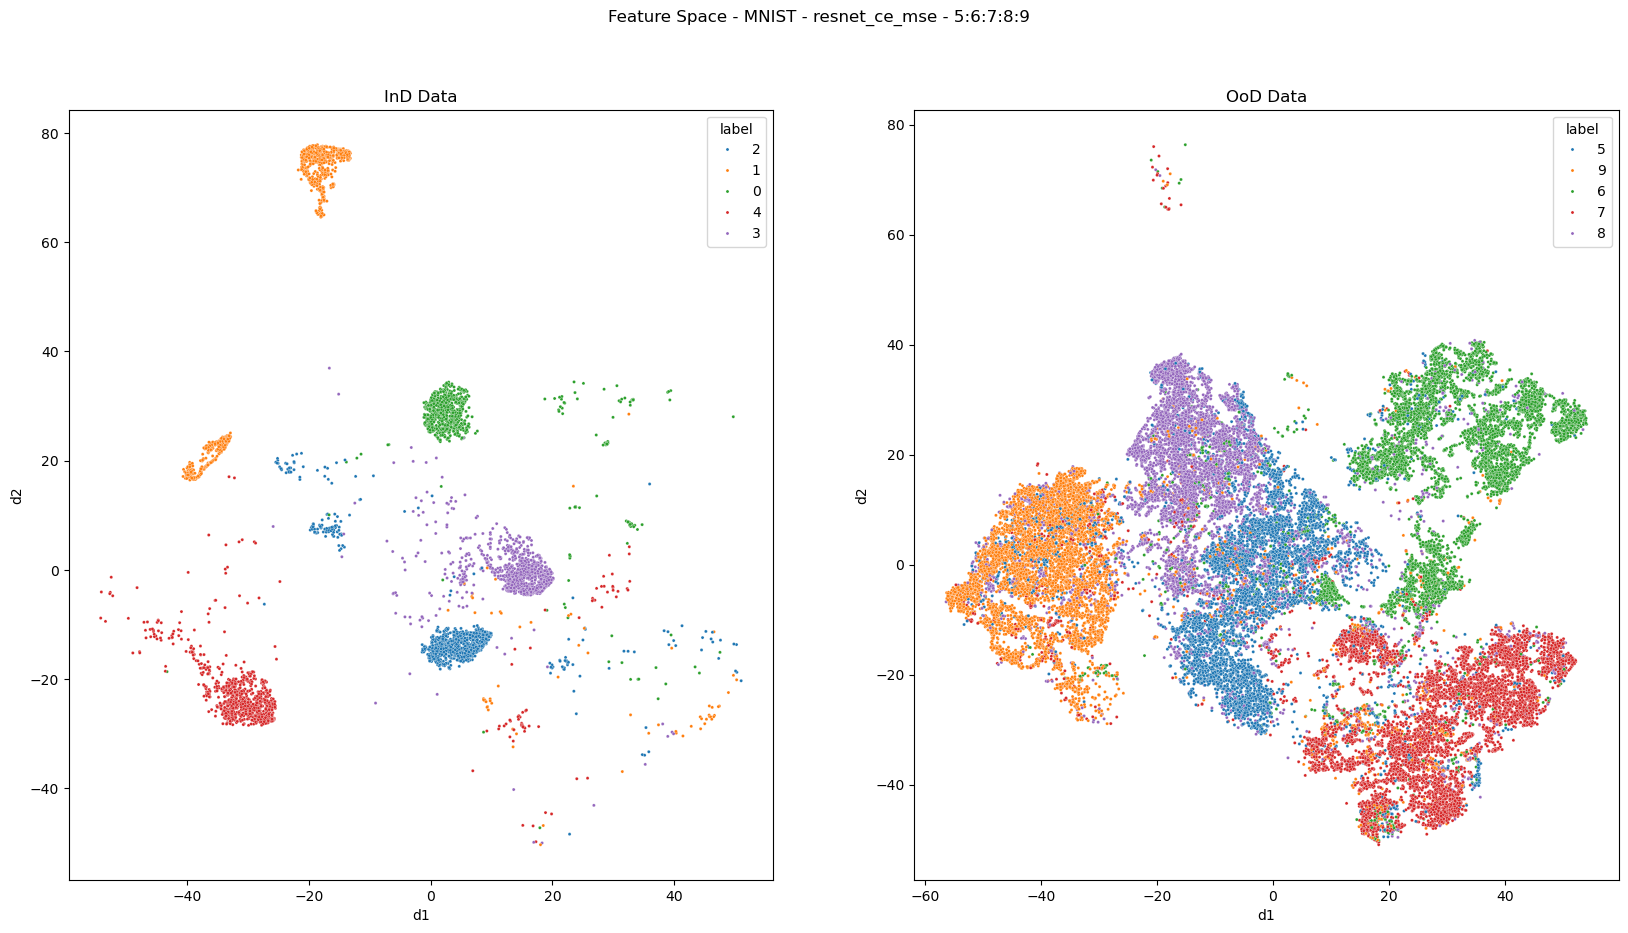

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

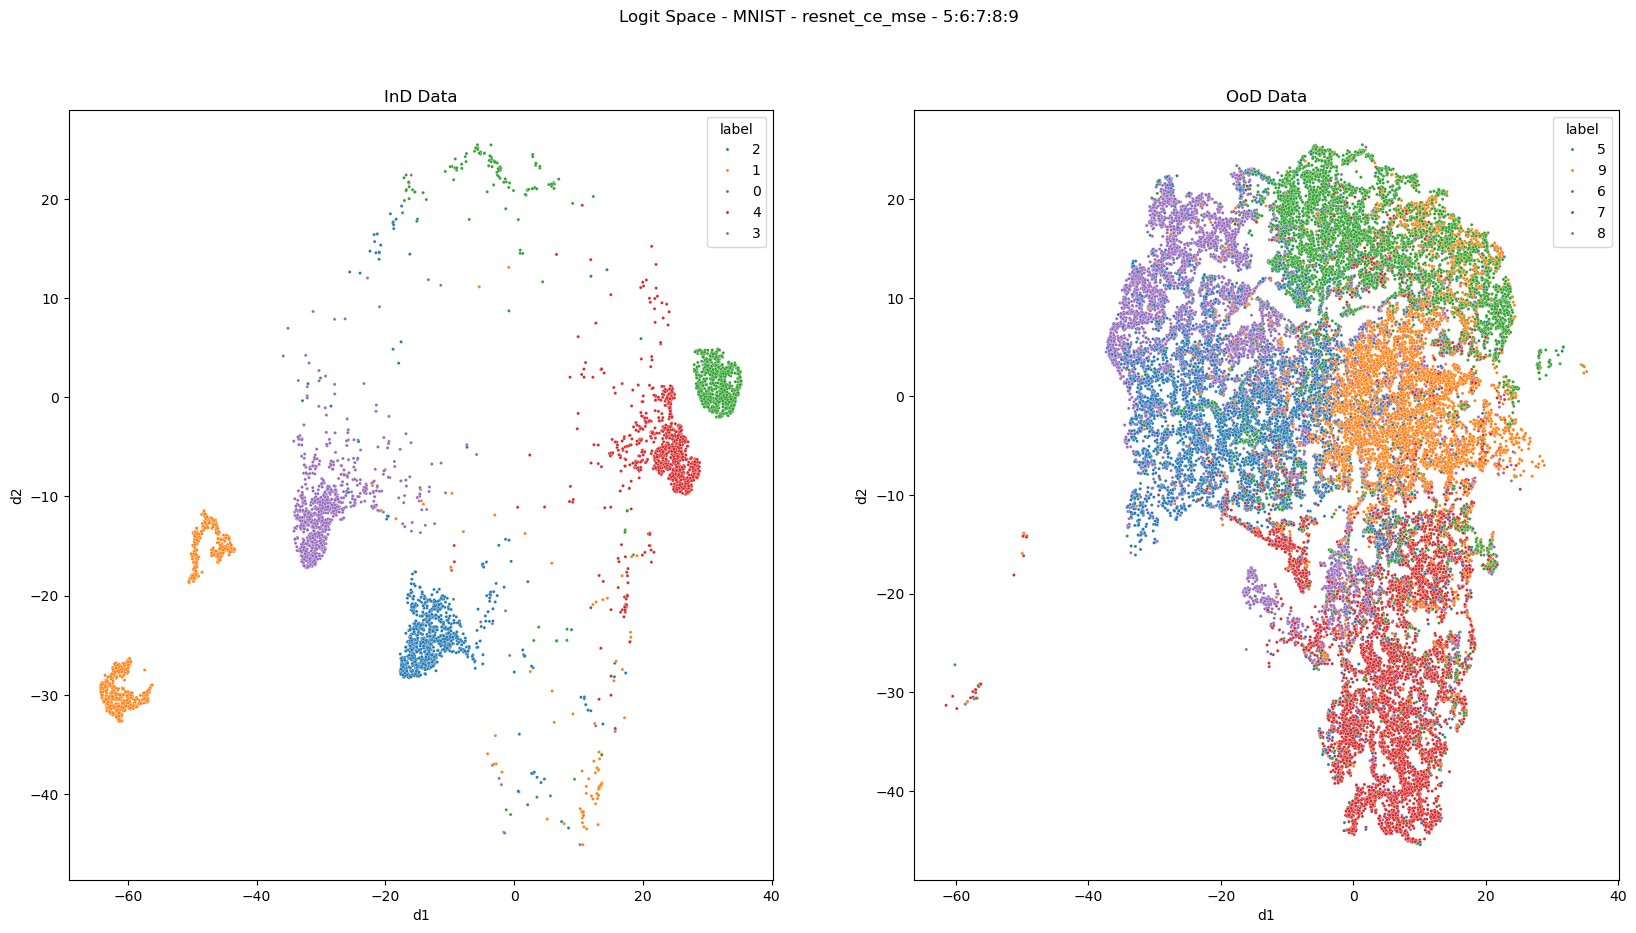

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.08s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.20s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.27s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]

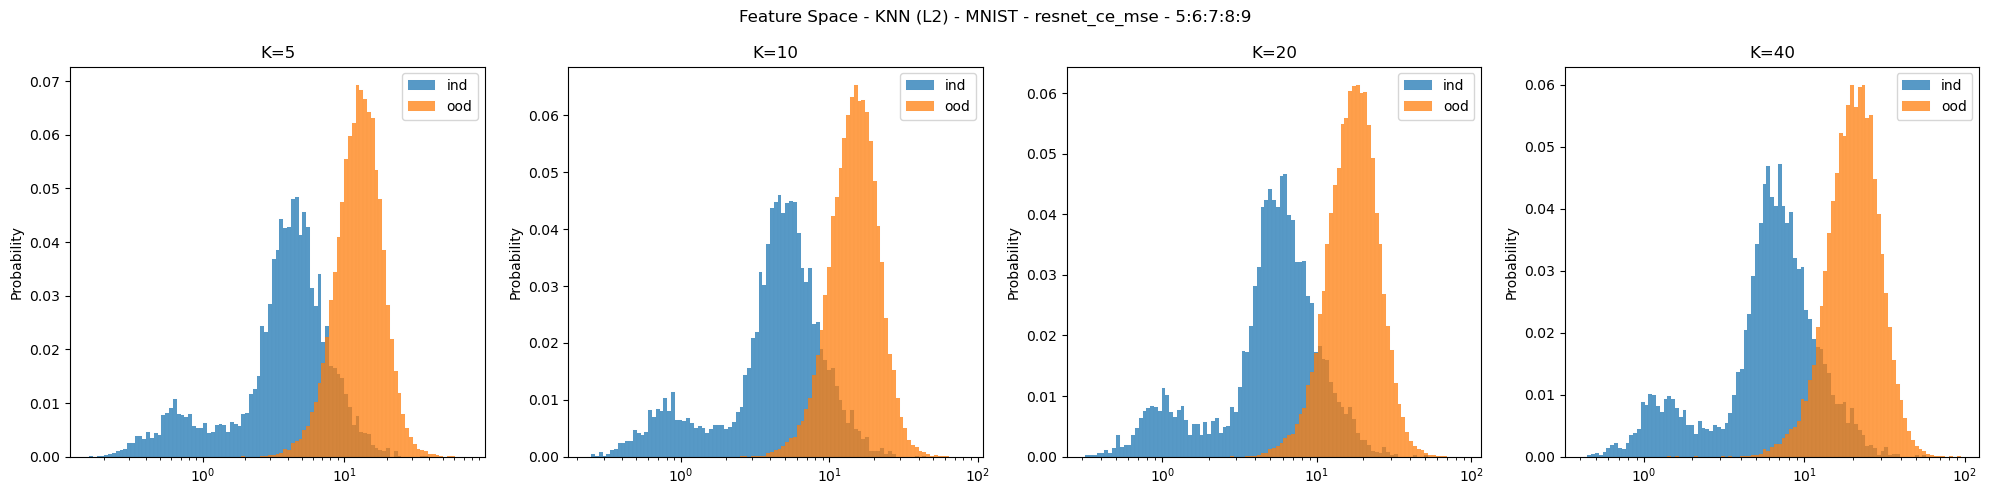

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.03s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.05s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.26s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.19s/it]

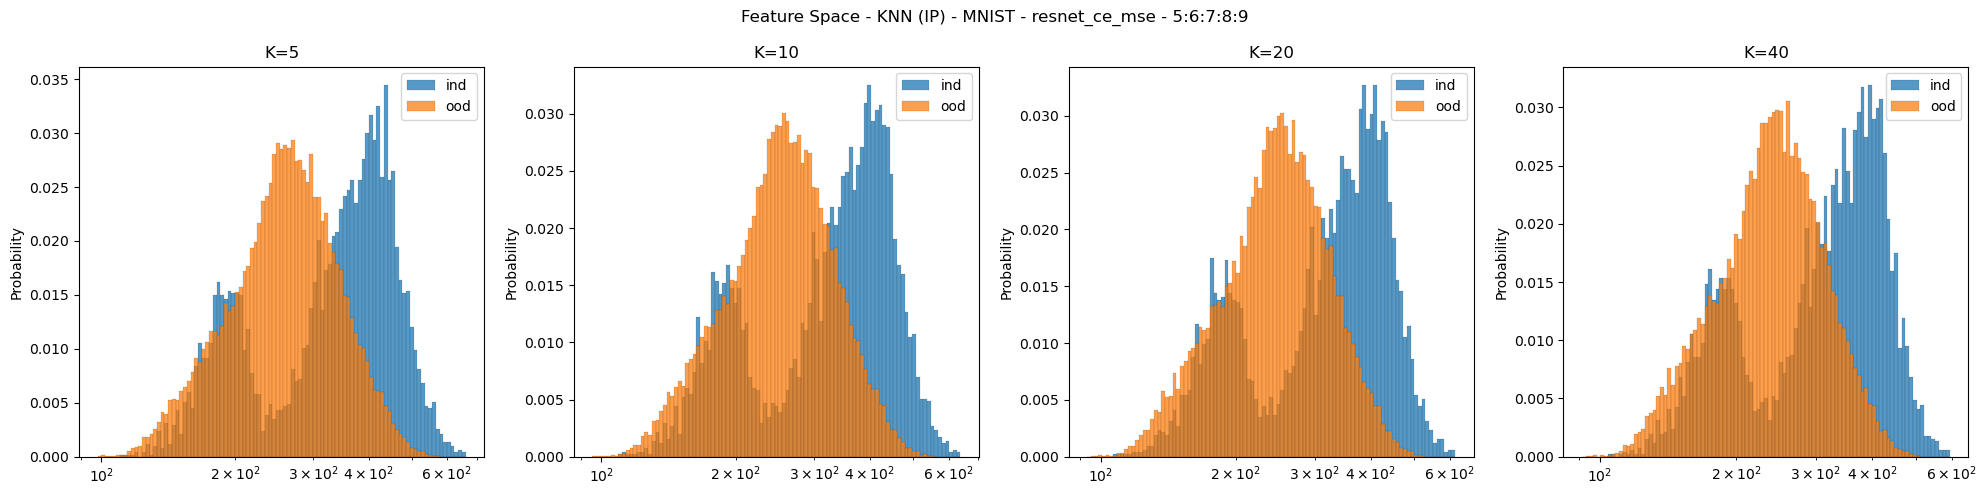

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.64it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.49it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.22it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]

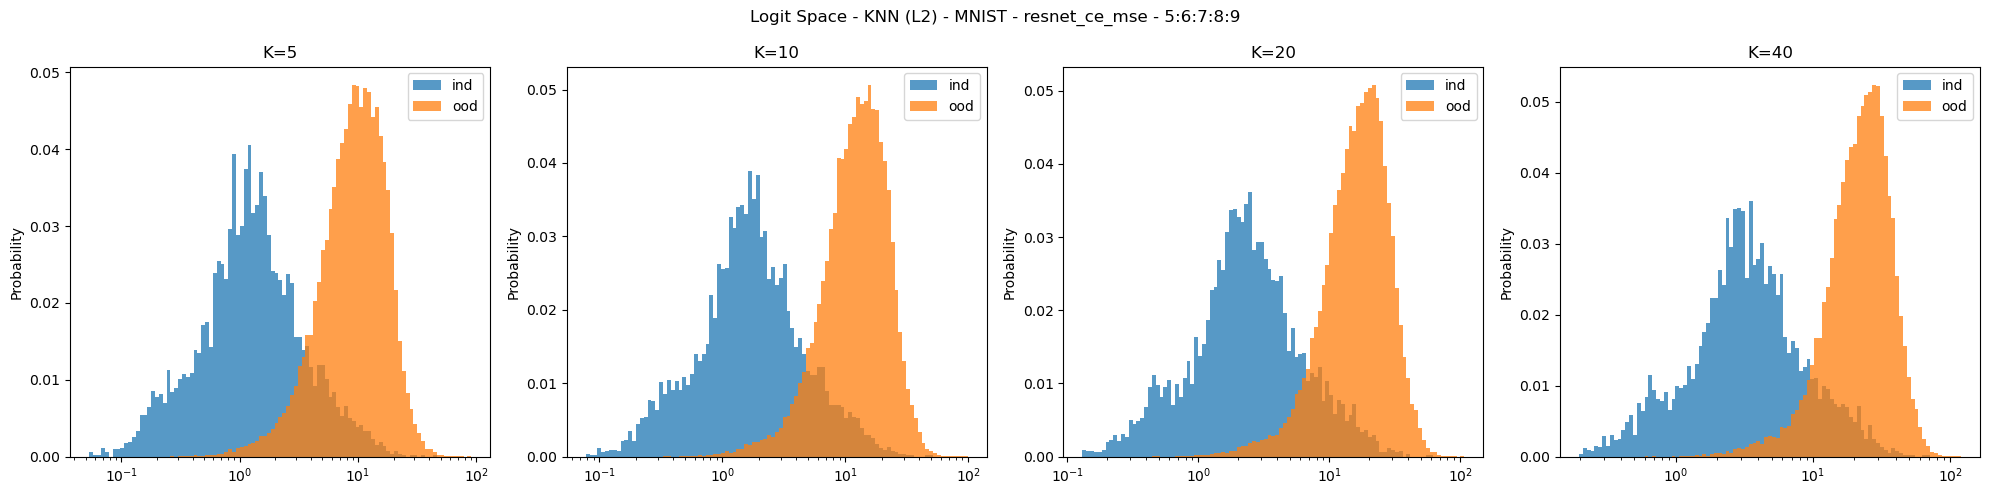

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.92it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.01it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.05it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]

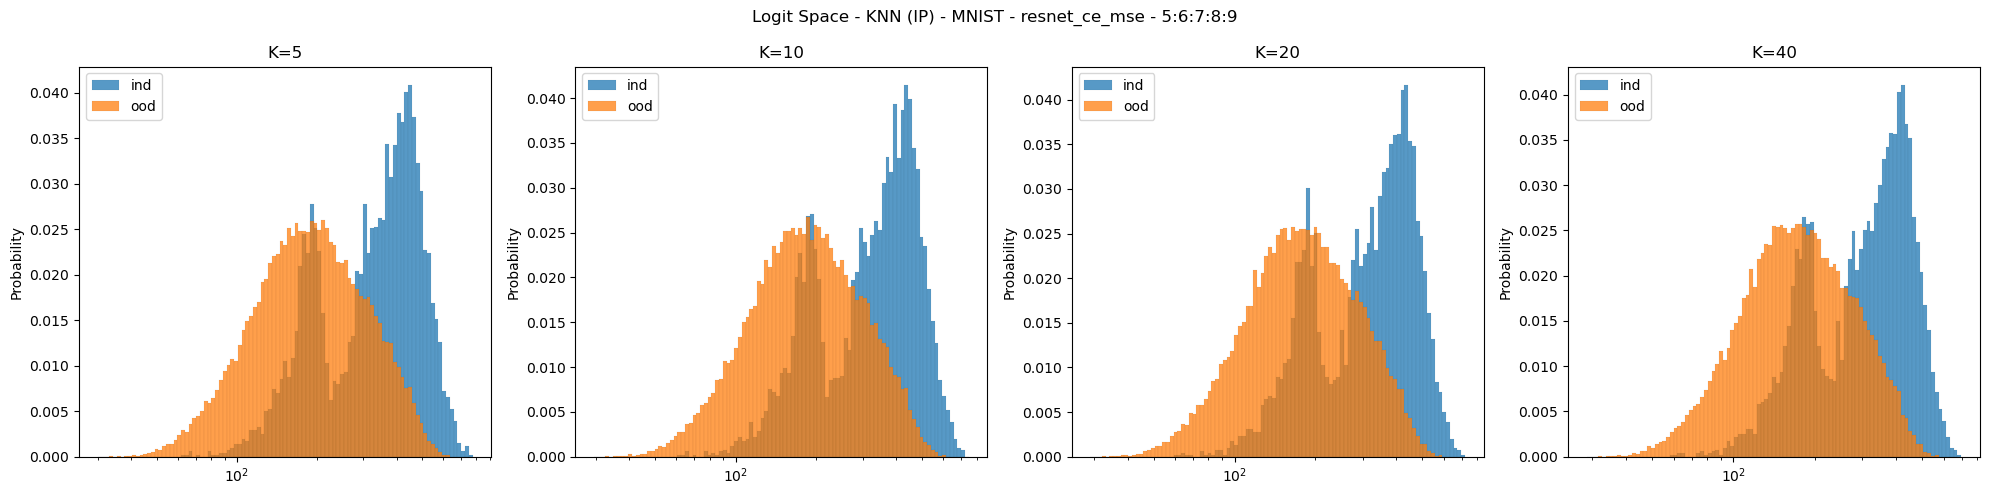

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

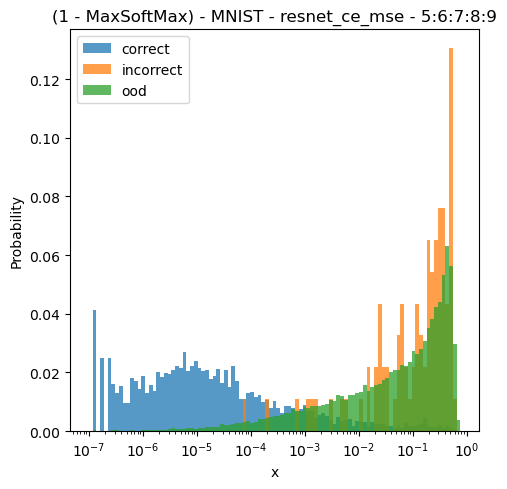

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

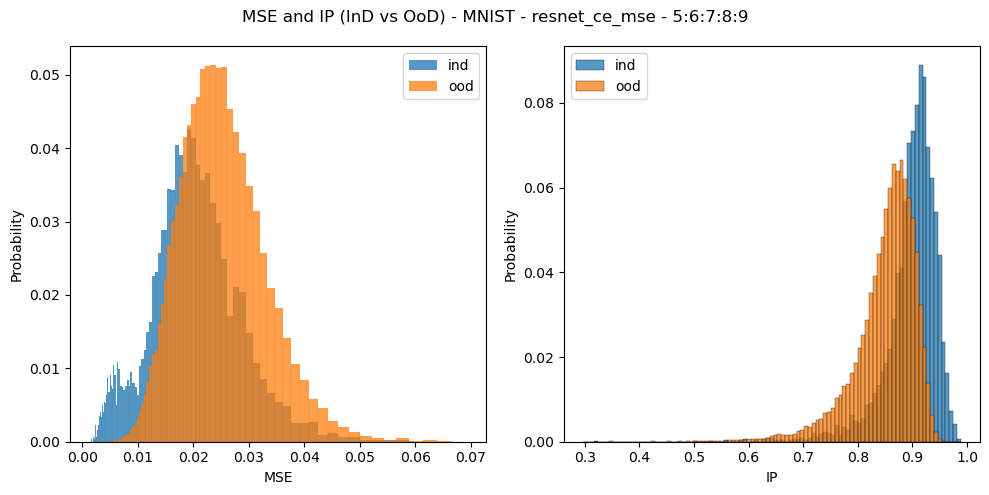

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()